In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, clear_output
import time

import os
import xarray as xr

import floater

import csv
import pandas as pd
from floater.generators import FloatSet

from skimage.feature import peak_local_max
from skimage import measure

from floater import rclv

from floater import rclv_mp
from floater import rclv_ci
from floater import rclv_zwd

from dask.diagnostics import ProgressBar

#from scipy import interpolate
from sklearn import preprocessing

import scipy.io
from scipy import interpolate
from xmitgcm import open_mdsdataset
from matplotlib.patches import Rectangle

In [2]:
data_dir1 = '/swot/SUM01/tongya/RCLV/output/flt_2d/001/float_trajectories_netcdf/'
ds1 = xr.open_mfdataset(data_dir1 + '*.nc')
ds1

<xarray.Dataset>
Dimensions:  (time: 91, x0: 11520, y0: 4800)
Coordinates:
  * y0       (y0) float32 0.00625 0.01875 0.03125 ... 59.96875 59.98125 59.99375
  * x0       (x0) float32 0.00625 0.01875 0.03125 ... 143.98125 143.99374
  * time     (time) int64 0 86400 172800 259200 ... 7603200 7689600 7776000
Data variables:
    x        (time, y0, x0) float32 dask.array<shape=(91, 4800, 11520), chunksize=(1, 4800, 11520)>
    y        (time, y0, x0) float32 dask.array<shape=(91, 4800, 11520), chunksize=(1, 4800, 11520)>
    z        (time, y0, x0) float32 dask.array<shape=(91, 4800, 11520), chunksize=(1, 4800, 11520)>
    u        (time, y0, x0) float32 dask.array<shape=(91, 4800, 11520), chunksize=(1, 4800, 11520)>
    v        (time, y0, x0) float32 dask.array<shape=(91, 4800, 11520), chunksize=(1, 4800, 11520)>
    vort     (time, y0, x0) float32 dask.array<shape=(91, 4800, 11520), chunksize=(1, 4800, 11520)>
    lavd     (time, y0, x0) float32 dask.array<shape=(91, 4800, 11520), chunks

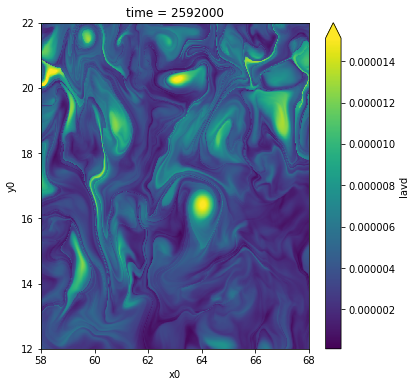

In [3]:
lc = 58
rc = 68
nc = 22
sc = 12

lavd1 = ds1.sel(x0=slice(lc,rc), y0=slice(sc,nc)).lavd[30,:,:] / (30*86400)
vor1 = ds1.sel(x0=slice(lc,rc), y0=slice(sc,nc)).vort[30,:,:]
z1 = ds1.sel(x0=slice(lc,rc), y0=slice(sc,nc)).z[30,:,:]
ds_lavd_1 = xr.Dataset(data_vars={'lavd': lavd1,'vort': vor1,'z':z1})

fig = plt.figure(figsize=(6,6))

ds_lavd_1.lavd.plot.pcolormesh(vmin=1e-7, vmax=1.511e-5)

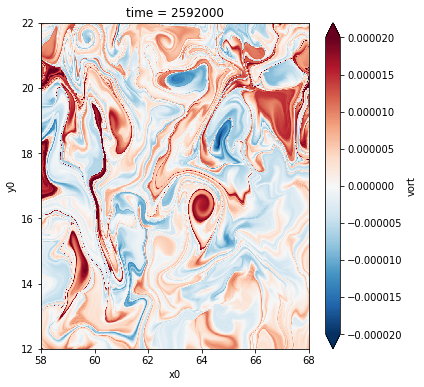

In [4]:
fig = plt.figure(figsize=(6,6))
ds_lavd_1.vort.plot.pcolormesh(vmin=-2e-5, vmax=2e-5, cmap='RdBu_r', extend='both')

In [5]:
lx0 = ds1.sel(x0=slice(lc,rc), y0=slice(sc,nc)).x[0,:,:]
lx1 = ds1.sel(x0=slice(lc,rc), y0=slice(sc,nc)).x[30,:,:]

ly0 = ds1.sel(x0=slice(lc,rc), y0=slice(sc,nc)).y[0,:,:]
ly1 = ds1.sel(x0=slice(lc,rc), y0=slice(sc,nc)).y[30,:,:]

lxt = (lx0.load().data, lx1.load().data)
lyt = (ly0.load().data, ly1.load().data)

  7%|▋         | 3/44 [00:00<00:01, 26.78it/s]/home/tls2913/tools/floater/floater/rclv_zwd.py:220: RuntimeWarning: invalid value encountered in float_scalars
  CI = (var_0-var_t)/var_0
100%|██████████| 44/44 [00:02<00:00, 21.07it/s]


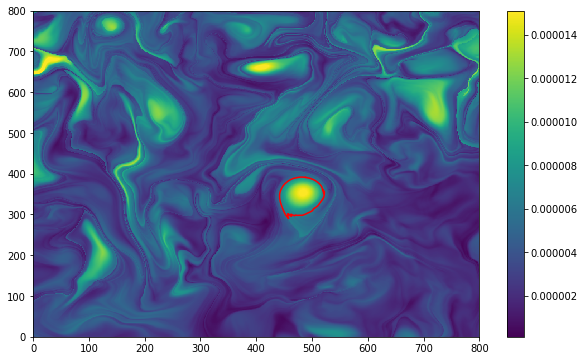

In [6]:
data_1 = ds_lavd_1.lavd
raw_1 = data_1.load().data

kw = dict(CI_th=-5.0, CI_tol=0.1, min_distance=32, min_limit_diff=1e-8,
          min_area=3024, max_footprint=100000, progress=True, convex_def=0.05, max_width=200)
boundaries_1 = list(rclv_zwd.find_convex_contours(raw_1,lxt, lyt, **kw))

fig = plt.figure(figsize=(10,6))
h1 = plt.pcolormesh(lavd1, vmin=1e-7, vmax=1.511e-5, rasterized=True)
plt.colorbar(h1)
for i in np.arange(0, len(boundaries_1), 1):
    data = boundaries_1[i][1]
    plt.plot(data[:,1], data[:,0], color='r')

In [21]:
from copy import deepcopy
vort = ds_lavd_1.vort.load().data

all_contours_1 = [r[1] for r in boundaries_1]
labels_1 = rclv.label_points_in_contours(raw_1.shape, all_contours_1)

mask_rclv = deepcopy(labels_1)
mask2 = deepcopy(labels_1) - 1
mask2[np.where(mask2 < 0)] = 1

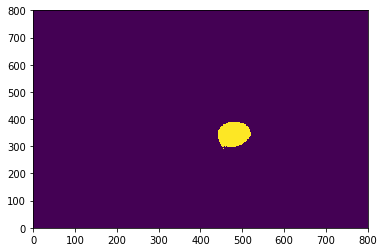

In [8]:
plt.pcolormesh(mask1)

In [9]:
px = ds1.sel(x0=slice(lc,rc), y0=slice(sc,nc)).x[:30, :, :].load().data
py = ds1.sel(x0=slice(lc,rc), y0=slice(sc,nc)).y[:30, :, :].load().data

pxin = px[0, :, :] * mask1
pyin = py[0, :, :] * mask1

pxout = px[0, :, :] * mask2
pyout = py[0, :, :] * mask2

pyin = np.reshape(pxin, (1, 800*800))
pyin.shape

(1, 640000)

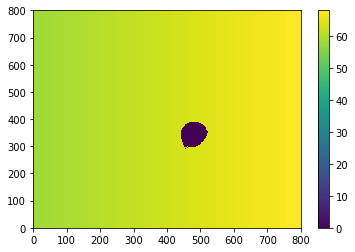

In [12]:
h1 = plt.pcolormesh(pxout)
plt.colorbar(h1)